In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display, HTML
from transformers import DistilBertModel, DistilBertTokenizer, logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pandas as pd
import numpy as np
import collections
from collections import Counter
import glob
import pickle
import random
from torch import cuda
from sklearn.metrics.pairwise import cosine_similarity
import sys
from sklearn.preprocessing import LabelBinarizer

In [2]:
logging.set_verbosity_error()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sys.path.insert(0, '../../src/models/')
sys.path.insert(0, '../../src/features/')

In [3]:
# Own Functions
from build_features import similarity_matrix as vector_values
from predict_model import load_CUB_Bert, load_simBERT, loadBERT
from predict_model import SpanPredictor as classify

In [4]:
output = 547

In [164]:
model = load_CUB_Bert("../../models/", 'saved_weights_DELETEIFNOTWORKING.pt', outputsize=output)

Local Success


In [5]:
POWO = pickle.load(open('../../data/processed/RDF_TEXT_POWO_SET_554.pkl', 'rb'))
TEST = pickle.load(open('../../data/processed/RDF_TEXT_TEST_SET_554.pkl', 'rb'))

In [145]:
#POWO['Raphionacme splendens']

In [115]:
#data_sorted =  {k: v for k, v in sorted(data_unsorted.items(), key = lambda item : len(item[1]), reverse=True)}

239

In [72]:
lb = LabelBinarizer()
keys = np.array([key for key in POWO.keys()])
keys_encoded = lb.fit_transform(keys)

In [165]:
def WhichPlant(span, model):

    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
        
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True, )
        # Predict class
        outputs = model(**inputs)
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        return np.squeeze(probs)
        
        # TESTING
        #outputs = outputs.detach().numpy()
        #return np.squeeze(outputs)

In [163]:
#WhichPlant('Basic flower parts has sub part pedicel.', model=model)

In [168]:
plant_idx = 100
species = list(TEST.keys())
plant = species[plant_idx]
print('NAME:', plant)

NAME: Erythrina fusca


In [172]:
#plant = list(data.keys())[1]
print(plant)

probs_stack = np.empty((0, output), float)
text_span = ''

for text in tqdm_notebook(TEST[plant][0:]):
    text_span += f'{text} ' 
    probs = WhichPlant(text_span, model=model)
    #probs = WhichPlant(text, model=model)
    probs_stack = np.vstack((probs_stack, probs))

Erythrina fusca


  0%|          | 0/54 [00:00<?, ?it/s]

In [170]:
text_span

'Erythrina fusca has main part leaves. Seed ellipsoid. Leaflet mostly paler. Basic flower parts has sub part seed. Erythrina fusca has main part basic flower parts. Stems has sub part stem. Leaves has sub part leaflet. Stems has sub part spine. Prickle almost straight. Other has sub part crown. Stem covered with short almost straight black prickles. Prickle glabrescent. Seed blackish with black markings. Prickle black. Erythrina fusca has main part stems. Seed dark brown. Stems has sub part prickle. Prickle short. Erythrina fusca has main part other. Seed longest dimension 1·2–1·8 cm. Stem pale. Seed oblong. '

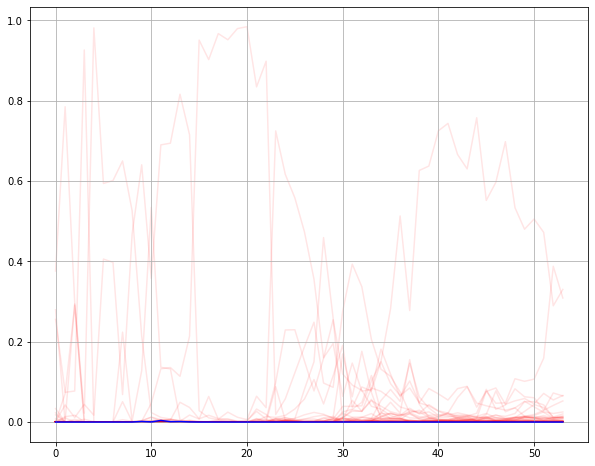

In [173]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(probs_stack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(probs_stack[:, i], color='red', alpha=0.1, zorder=1)
plt.grid()

In [18]:
correct =  probs_stack[:, i]
uncorrect = np.delete(probs_stack, i, axis=1)

In [19]:
#uncorrect[0]

In [103]:
correct     = []
not_correct = []

for plant in tqdm_notebook(species[0:20]):
    # Index plant
    idx = np.where(lb.classes_ == plant)[0][0]
    for text in TEST[plant]:
        probabilities = WhichPlant(text, model=model)
        correct.append(probabilities[idx])
        not_correct += list(np.delete(probabilities, idx))

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
from scipy import stats

In [27]:
correct = np.array(correct)

In [31]:
not_correct = np.array(not_correct)

In [48]:
not_correct.shape

(2697232,)

In [49]:
not_correct.mean()

0.004242892

In [95]:
stats.ttest_ind(correct, not_correct, alternative='greater', equal_var=False)

Ttest_indResult(statistic=21.50270960117851, pvalue=2.8752799121436165e-84)

<AxesSubplot:>

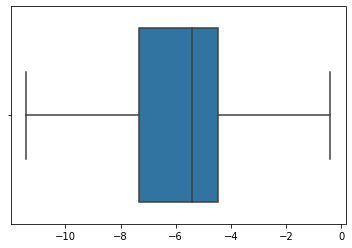

In [98]:
sns.boxplot(correct, showfliers=False)

<AxesSubplot:>

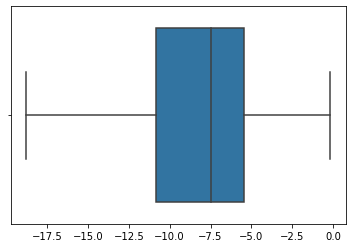

In [92]:
sns.boxplot(not_correct, showfliers=False)

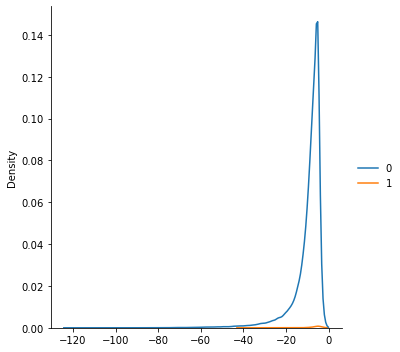

In [96]:
sns.displot([not_correct, correct], kind="kde", cut=0)

In [ ]:
#pos_array = np.array(data[plant][0:])
#idx = np.where(lb.classes_ == plant)[0][0]
#pos_array[probs_stack[:, idx] > .9]

In [ ]:

data_plants = collections.defaultdict(list)
data_plants_all = collections.defaultdict(list)

for plant in tqdm_notebook(species[0:]):
    
    for text in TEST[plant]:
    #for row in important_stuff:
        #text_span += f' {row}.' 
        probabilities_stacked = WhichPlant(text, model=model)
        
        idx = np.where(lb.classes_ == plant)[0][0]
        data_plants[plant].append(probabilities_stacked[idx])

In [ ]:
len(data_plants_all['Boswellia sacra'])

In [ ]:
pred_correct   = []
pred_uncorrect = []

for plant in species[0:1]:
    for values in data_plants_all[plant]:
        values

In [ ]:
idx = np.where(lb.classes_ == plant)[0][0]

In [ ]:
values.shape

In [ ]:
total = []
for plant in species:
    total += data_plants[plant]
    
total = np.array(total)

In [ ]:
sns.displot(total[total < 0.4], kind="ecdf")

In [ ]:

fig, ax = plt.subplots(figsize=(10, 8))

for plant in species:
    ax.plot(data_plants[plant], alpha=0.3, color='blue')
plt.grid()
#plt.legend()
plt.show()



In [ ]:
def check_values(sents):
    
    count = 0
    # Check other combinations
    for species in data.keys():
        length = len(set(sents).intersection(data[species]))
        if length == len(sents):
            count += 1
        
    return count

In [ ]:
text_list = []
pred_sing = []
pred_mult = []
single_other = []
multip_other = []

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    text_list.append(row)
    pred_sing.append(output / value / output)
    if idx != 0 and pred_mult[-1] == 1:
        pred_mult.append(1)
    else:
        pred_mult.append(output / check_values(text_list) / output)
            

In [ ]:
pred_sing = []
pred_all_single = np.zeros(shape=(len(plant_list[0:]), output))

for idx, (row, value) in enumerate(tqdm_notebook(plant_list[0:])):
    temp_s = []
    for x in data.keys():
        if row in data[x]:
            temp_s.append(output / value / output)
        else:
            temp_s.append(0)
    pred_all_single[idx] = temp_s


In [ ]:
#len(species)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == plant_idx:
        ax.plot(pred_all_single[:, i], color='blue', alpha=1, markersize=5, zorder=2, )
    else:
        ax.plot(pred_all_single[:, i], color='red', alpha=0.05, zorder=1,)
plt.plot(pred_mult, color='orange')
plt.grid()

In [ ]:
text_list[0:np.array(pred_mult).argmax()]

In [6]:
device = 'cuda' if cuda.is_available() else 'cpu'

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [7]:
for param in bert.parameters():
    param.requires_grad = False

In [8]:
class BERT(nn.Module):
    def __init__(self, bert):
        
        super(BERT, self).__init__()
        
        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 1024)
        self.fc2 = nn.Linear(1024, 512)
        # Linear II (Out)
        self.fc3 = nn.Linear(512, 547)
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)


    # Forward pass
    def forward(self, sent_id, mask):

        # Pass data trough bert and extract 
        cls_hs = self.bert(sent_id, attention_mask=mask)
        # Extract hidden state
        hidden_state = cls_hs.last_hidden_state
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        
        # Dense layer 1        
        x = self.fc1(pooler)
        x = self.relu(x)
        x = self.fc2(x)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc3(x)
        # Activation
        x = self.softmax(x)

        return x

In [9]:
# Load the entire model
model = BERT(bert)

# Load trained model (colab)

model_save_name = 'saved_weights_DELETEIFNOTWORKING2.pt'
path = "../../models/" + model_save_name
model.load_state_dict(torch.load(path, 
                                 map_location=torch.device('cpu')))
print('Local Success')

# Push the model to GPU
model = model.to(device)

Local Success


In [10]:
POWO = pickle.load(open('../../data/processed/RDF_TEXT_POWO_SET_554.pkl', 'rb'))
TEST = pickle.load(open('../../data/processed/RDF_TEXT_TEST_SET_554.pkl', 'rb'))

In [11]:
def sort_dict(data):
    
    data_list = []
    for key in data.keys():
        data_list += data[key]

    count = Counter(data_list)
    
    data_sorted = collections.defaultdict(list)
    for plant in data.keys():
        plant_list = []
        for text in data[plant]:
            rank = count[text]
            plant_list.append((text, rank))
            plant_list = list(set(plant_list))
            plant_list = sorted(plant_list, key=lambda x: x[1], reverse=True)
        for (text, _) in plant_list:
            data_sorted[plant].append(text)
    
    return data_sorted

In [12]:
def WhichPlant(span, model):

    """
    Uses a trained bert classifier to see if a span
    belongs to a species description or otherwise.
    """
        
    with torch.no_grad():
        # Tokenize input
        inputs = tokenizer(span, return_tensors="pt", truncation=True, )
        #print(inputs.keys())
        # Predict class
        outputs = model(sent_id = inputs['input_ids'],
                       mask = inputs['attention_mask'])
        # Get prediction values
        exps = torch.exp(outputs)
        # Get class
        probs = exps.detach().numpy()
        
        return np.squeeze(probs)

In [13]:
#WhichPlant('this is a test.', model=model)

In [14]:
data_sorted = sort_dict(POWO)

In [15]:
train = pickle.load(open('../../data/processed/DELETEIFNOTWORKING_TRAIN.pkl', 'rb'))
lb = LabelBinarizer()
keys = np.array([key for key in POWO.keys()])
keys_encoded = lb.fit_transform(keys)

In [16]:
species = list(data_sorted.keys())

In [22]:
plant_idx = 333
plant = species[plant_idx]
print('NAME:', plant)

NAME: Crotalaria trichotoma


In [25]:
#plant = list(data.keys())[1]
print(plant)

probs_stack = np.empty((0, output), float)
text_span = ''

for text in tqdm_notebook(TEST[plant][0:]):
    text_span += f'{text} ' 
    probs = WhichPlant(text_span, model=model)
    #probs = WhichPlant(text, model=model)
    probs_stack = np.vstack((probs_stack, probs))

Crotalaria trichotoma


  0%|          | 0/49 [00:00<?, ?it/s]

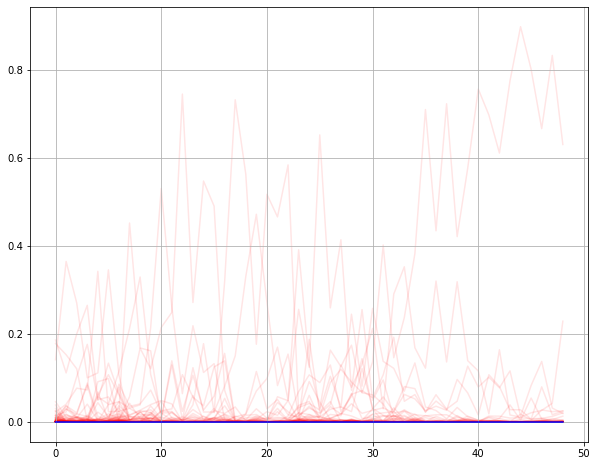

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(0, output):
    if i == np.where(lb.classes_ == plant)[0][0]:
        ax.plot(probs_stack[:, i], color='blue', alpha=1, markersize=5, zorder=2)
    else:
        
        ax.plot(probs_stack[:, i], color='red', alpha=0.1, zorder=1)
plt.grid()

In [250]:
data_sorted[plant]

['Basic flower parts has sub part seed.',
 'Other has sub part apex.',
 'Bryophytes has sub part inflorescence.',
 'Stems has sub part branch.',
 'Stems has sub part bark.',
 'Bryophytes has sub part capsule.',
 'Other has sub part crown.',
 'Seed dark brown.',
 'Seed obliquely truncate at the base.',
 'Crown scale-like pieces 3–6 cm.',
 'Crown grey-brown.',
 'Entandrophragma utile has main part bryophytes.',
 'Entandrophragma utile has main part basic flower parts.',
 'Crown bark thick.',
 'Crown scarcely tapered.',
 'Crown buttresses rounded.',
 'Seed 9.5times2 cm.',
 'Crown extending up the bole for 2–5 m.',
 'Entandrophragma utile has main part other.',
 'Crown cylindrical.',
 'Crown bole long.',
 'Entandrophragma utile has main part stems.',
 'Branch few though massive.',
 'Crown regularly cracked and fissured into squarish.',
 'Crown regular with few though massive branches and with the leaves clustered at the ends of thick branchlets.']